In [29]:
import librosa
from PIL import Image
import numpy as np
import pretty_midi_fluidsynth as pmf

import matplotlib.pyplot as plt
import librosa.display

import os
from tqdm import tqdm

In [7]:
data_path = './test_data'
x_path = os.path.join(data_path,'wav')
y_path = os.path.join(data_path,'midi')

In [8]:
len(os.listdir(y_path))

900

In [9]:
hop_len = 441
freq_w = 4
octave = 8

n_bins = 12*freq_w*octave
bins_per_octave = 12*freq_w

sr = 44100
fs = 25

idx=0

# midi

In [10]:
file_list = os.listdir(y_path)
path = os.path.join(y_path,file_list[idx])

midi_data = pmf.PrettyMIDI(path)

piano_roll = midi_data.get_piano_roll(fs)

start_pitch = 24
end_pitch = 120

piano_roll[start_pitch:end_pitch,:].shape

(96, 300)

In [11]:
sec = piano_roll.shape[1]//fs
sec

12

C:\Users\AI_server\miniconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


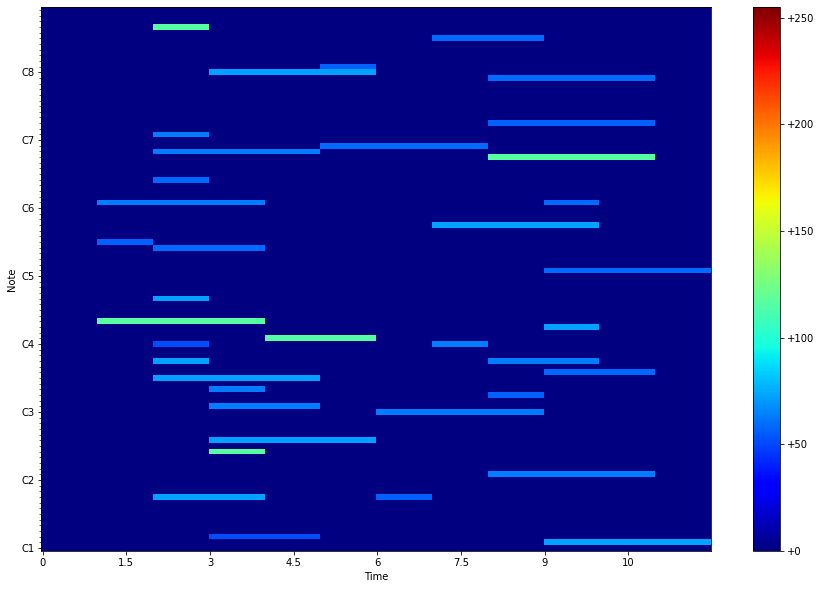

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    piano_roll[start_pitch:end_pitch,:],
    hop_length=1,
    sr=fs,
    ax=ax,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch),
    vmin=0,
    vmax=255,
)
fig.colorbar(img, ax=ax, format="%+2d")
plt.show()

In [13]:
piano_roll.max()

116.0

# wav

In [14]:
file_list = os.listdir(x_path)
path = os.path.join(x_path,file_list[idx])
audio_data, _ = librosa.load(path,sr=sr)
audio_data.shape[0]//sr

13

In [15]:
cqt = librosa.cqt(audio_data, sr=sr,
                  hop_length= hop_len,
                  n_bins= 12*freq_w*octave,
                  bins_per_octave= 12*freq_w,
                 )

In [16]:
cqt[:,:sr//hop_len*sec].shape

(384, 1200)

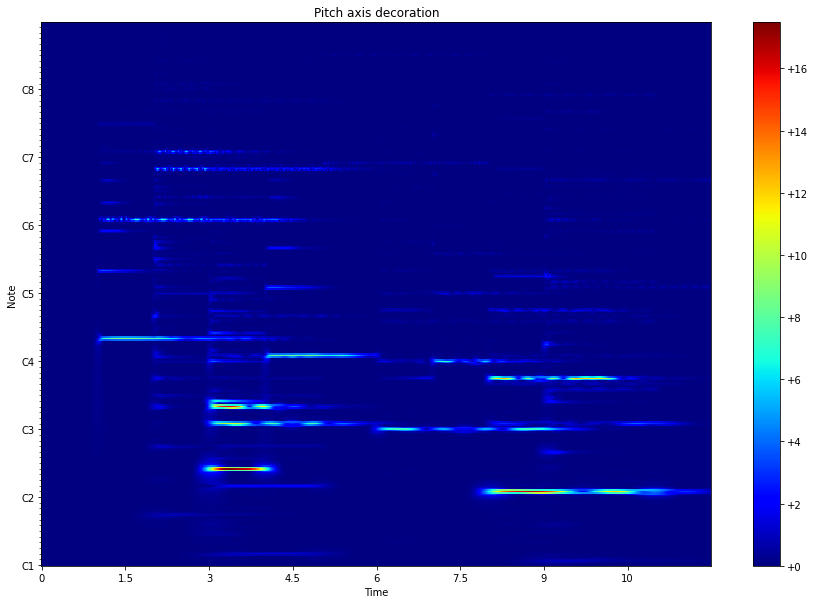

In [17]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(np.abs(cqt[:,:sr//hop_len*sec]), sr=sr,
                               x_axis='time',
                               y_axis='cqt_note', 
                               ax=ax,
                               hop_length= hop_len,
                               bins_per_octave= 12*freq_w,
                               cmap='jet'
                               )
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2d")
# for i in beat_times:
#     ax.axvline(i,c='k')

plt.show()

# instruments's constant-Q

In [30]:
midi_data = pmf.PrettyMIDI()
cqt_list = []
for i in tqdm(range(128)):
    instr = pmf.Instrument(program=i)
    instr.name = pmf.program_to_instrument_name(i)
    pitch = pmf.note_name_to_number("C4")
    start_time = 1
    end_time = 2
    note = pmf.Note(velocity=100,
                   pitch=pitch,
                   start=start_time,
                   end=end_time,)
    instr.notes.append(note)
    midi_data.instruments.append(instr)
    
    audio_data = midi_data.fluidsynth(sr)
    
    cqt = librosa.cqt(audio_data, sr=sr,
                  hop_length= hop_len,
                  n_bins= 12*freq_w*5,
                  bins_per_octave= 12*freq_w,
                 )
    cqt_list.append((instr.name, cqt))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [18:24<00:00,  8.63s/it]


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

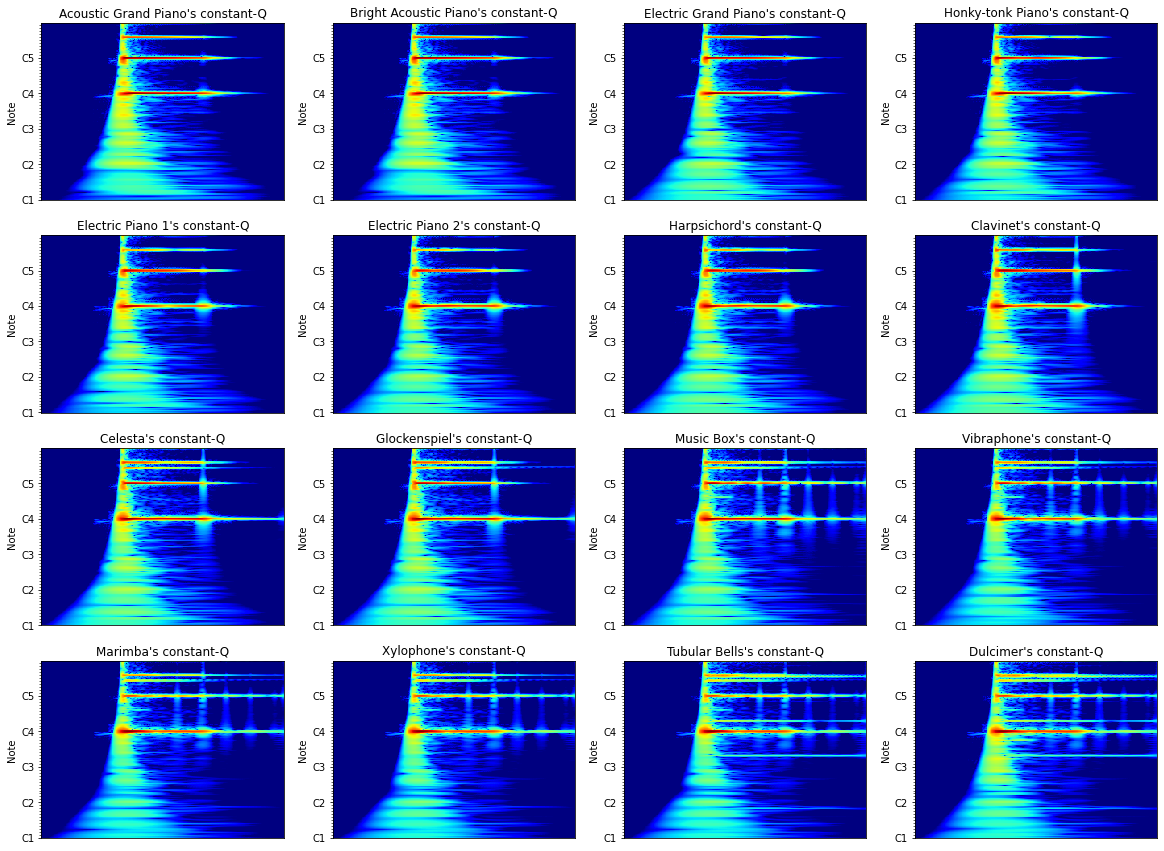

 11%|█████████▎                                                                          | 1/9 [00:06<00:49,  6.20s/it]

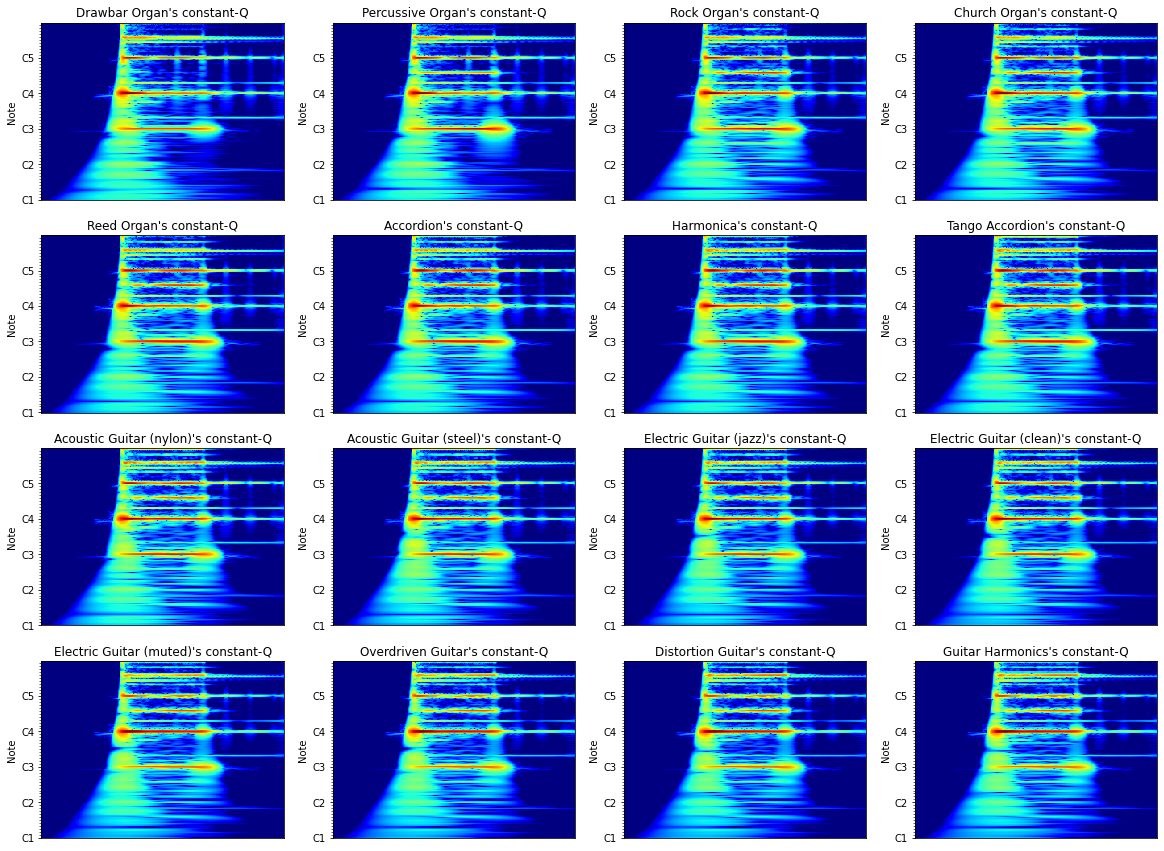

 22%|██████████████████▋                                                                 | 2/9 [00:13<00:46,  6.62s/it]

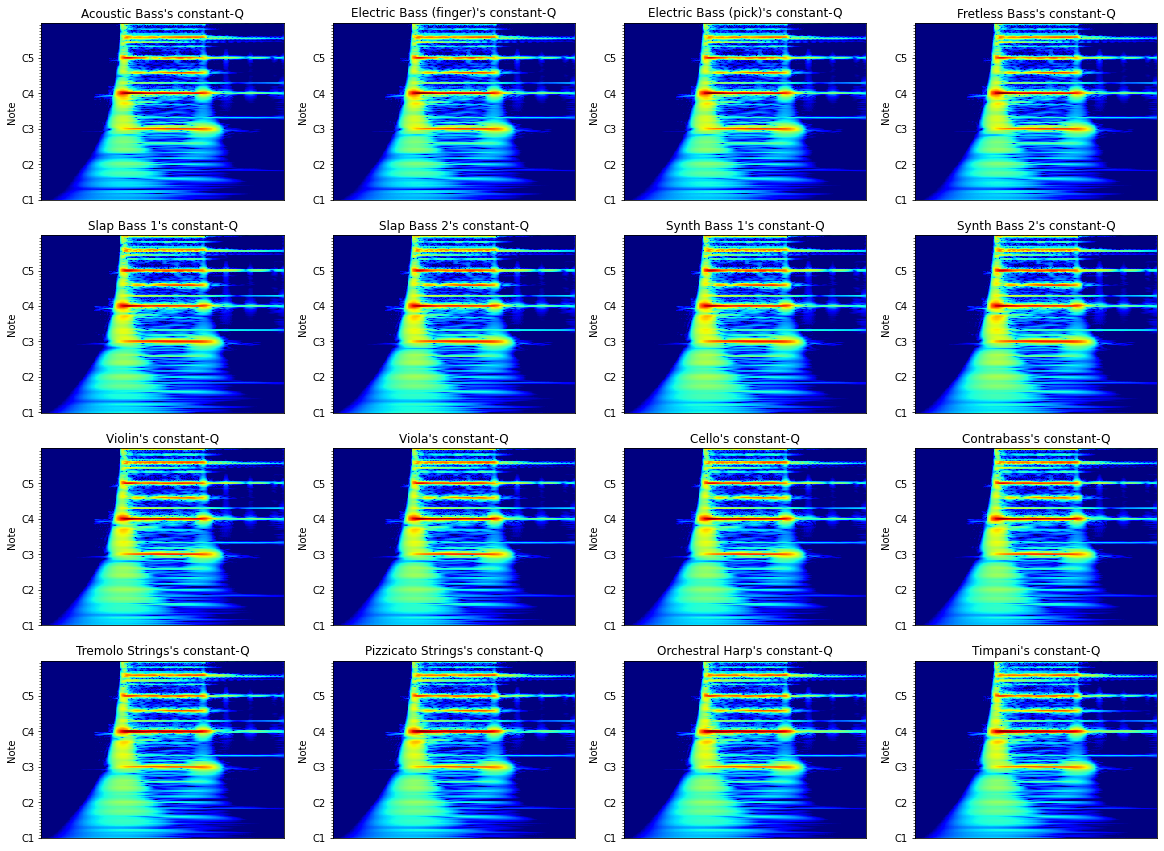

 33%|████████████████████████████                                                        | 3/9 [00:19<00:38,  6.40s/it]

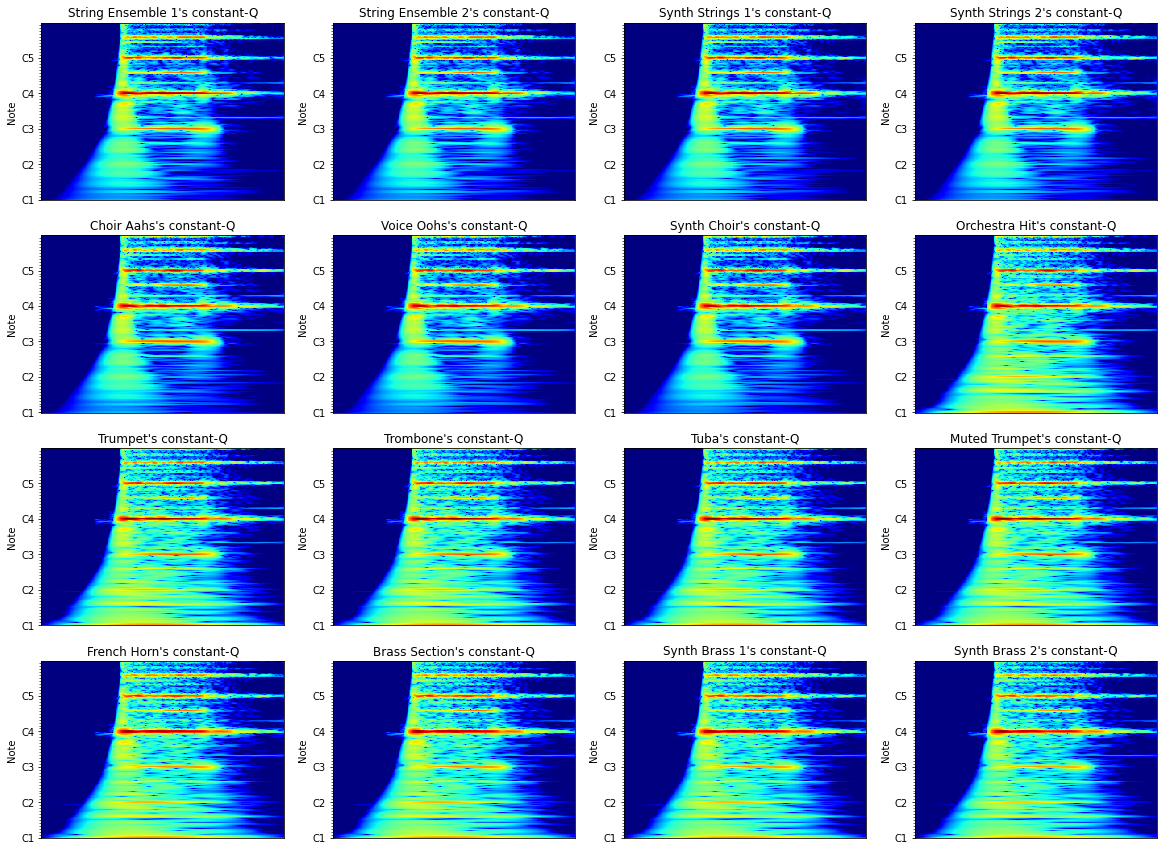

 44%|█████████████████████████████████████▎                                              | 4/9 [00:26<00:33,  6.61s/it]

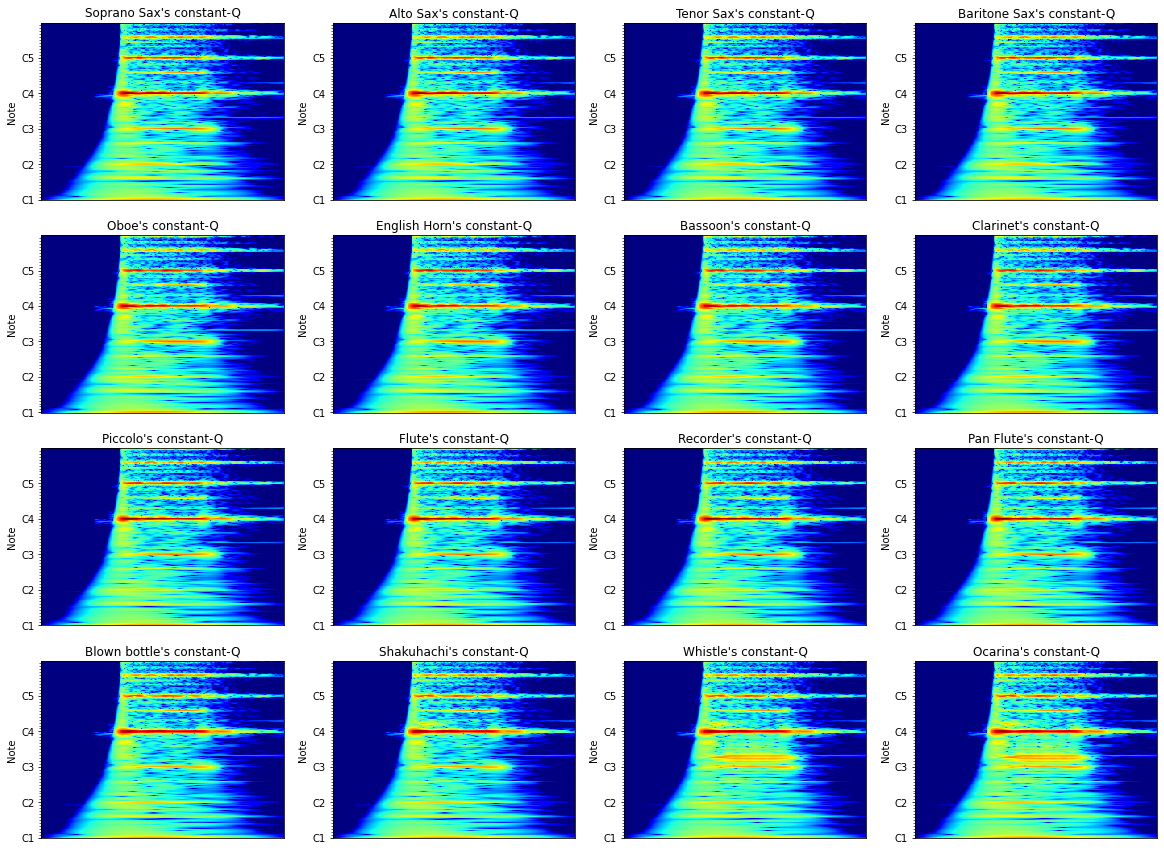

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:32<00:26,  6.62s/it]

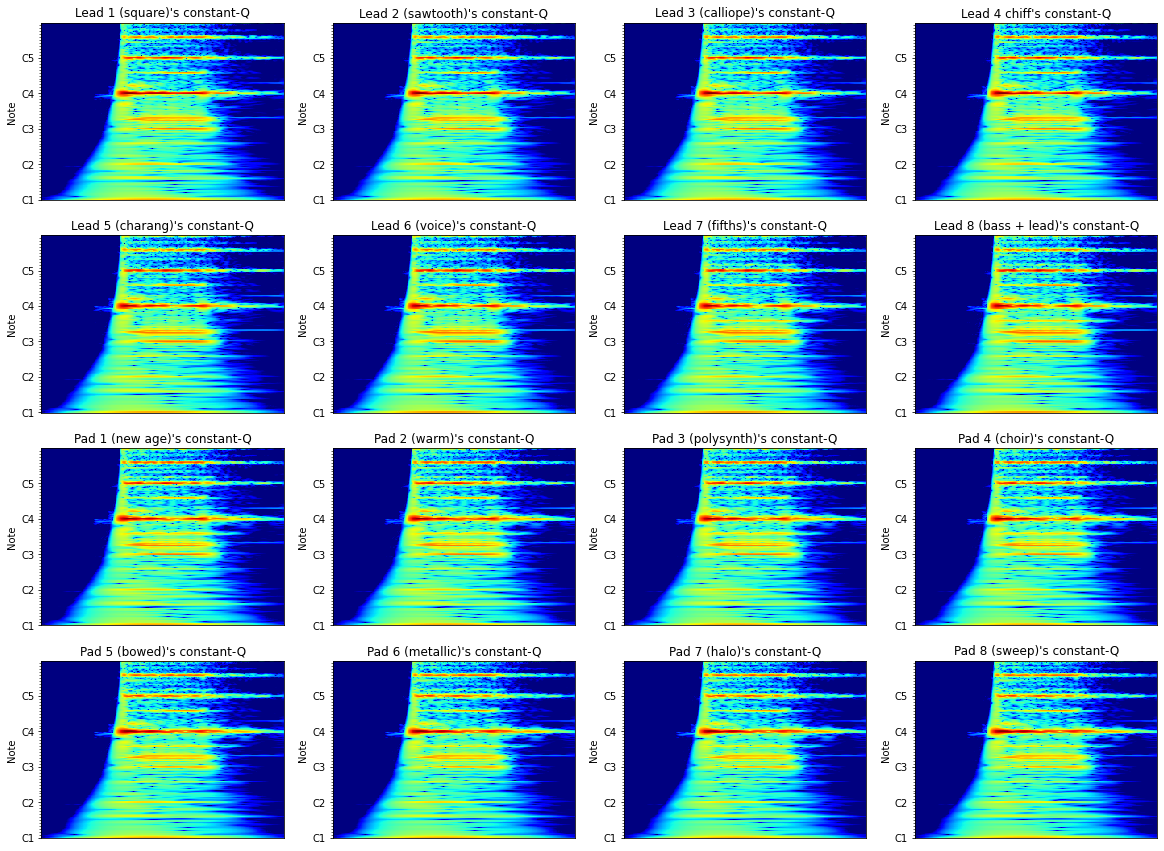

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:38<00:19,  6.46s/it]

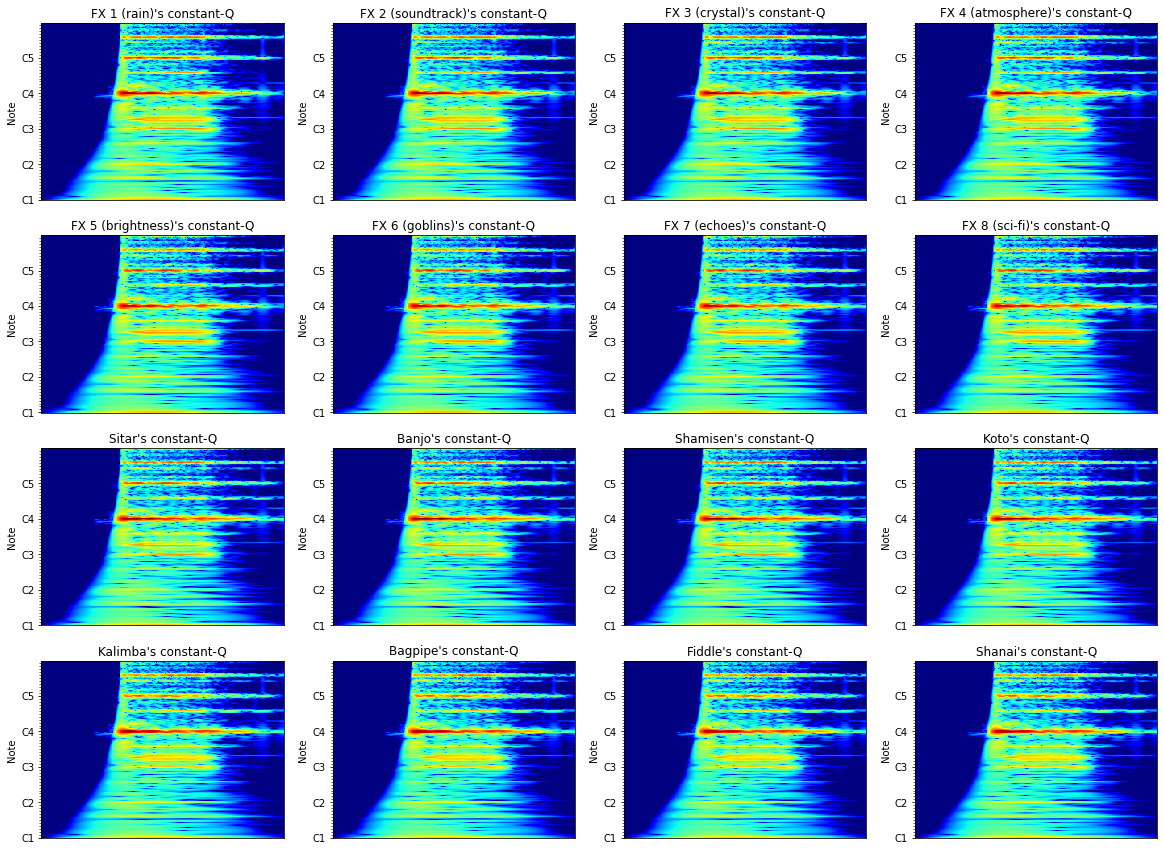

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:45<00:13,  6.57s/it]

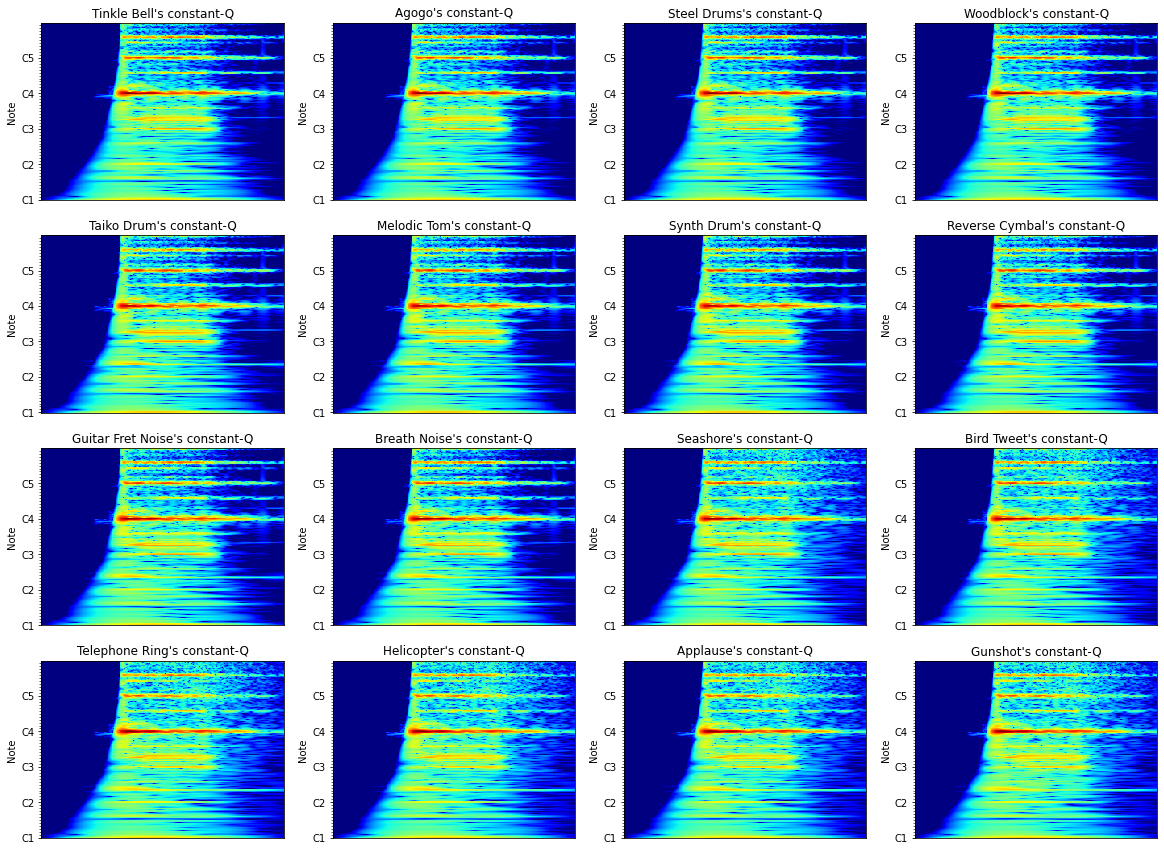

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:51<00:06,  6.41s/it]

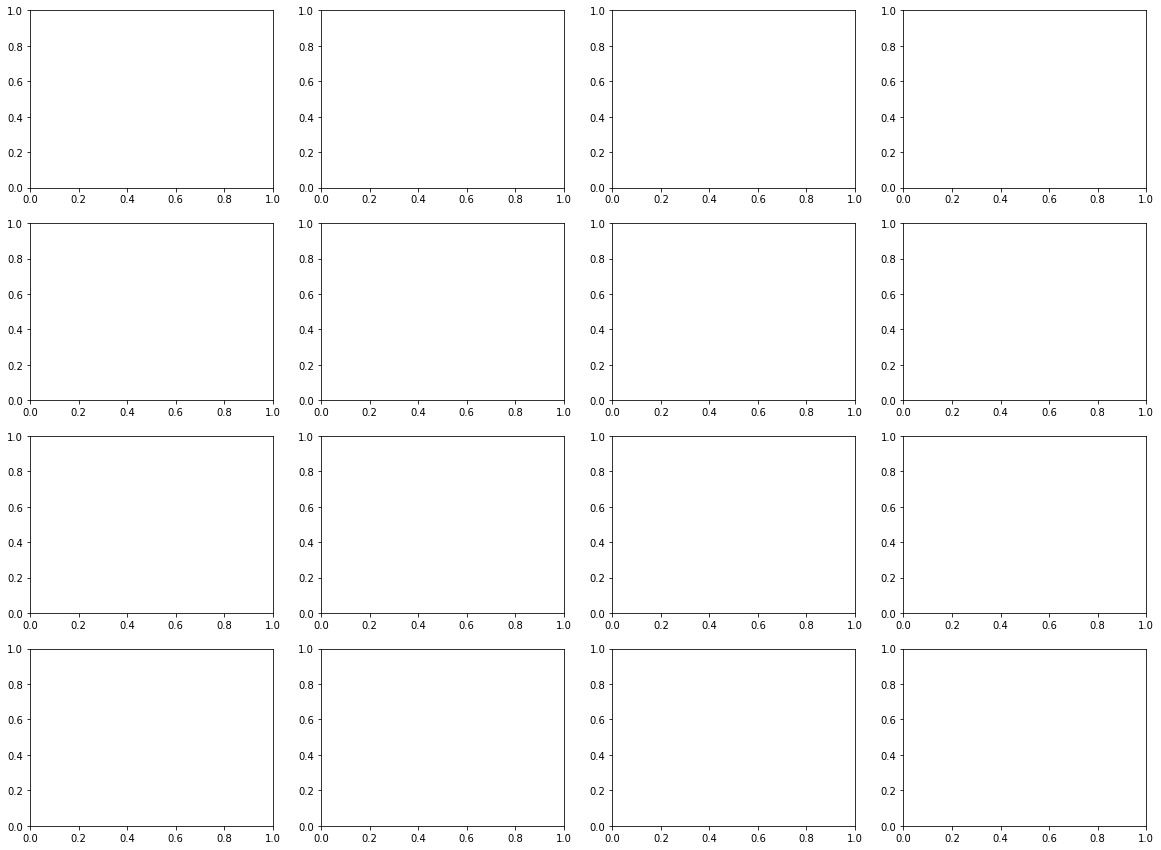

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:53<00:00,  5.97s/it]


In [60]:
row,col = 4,4
n = row*col

for idx in tqdm(range(128//n+1)):
    fig, ax = plt.subplots(row, col, figsize=(20,15))

    for i, (name,cqt) in enumerate(cqt_list[n*(idx):n*(idx+1)]):
        cqt_db = librosa.amplitude_to_db(
            np.abs(cqt),
            ref=np.max
        )
        img = librosa.display.specshow(
            cqt_db, sr=sr,
    #         x_axis='time',
            y_axis='cqt_note',
            ax=ax[i//4][i%4],
            hop_length= hop_len,
            bins_per_octave= 12*freq_w,
            cmap='jet',
        )
        ax[i//4][i%4].set(title=f"{name}'s constant-Q")
    #     fig.colorbar(img, ax=ax[i//4][i%4], format="%+2d")

    plt.show()